In [147]:
import numpy as np
import matplotlib.pyplot as plt

import os
from numba import cuda
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim



from tqdm import tqdm


In [148]:
# device = cuda.get_current_device()
# device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cpu


## Function we want to learn

In [149]:
E0 = 500

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def f(x): # 1st order approximation to the function

    alpha_s_scale = alpha_s(x * E0) # GeV
    C_F = 4/3
    C_A = 3

    return -(alpha_s_scale * C_F / (1 * np.pi)) * torch.log(x ) / x


def true_f(x): # 1st order approximation to the function

    alpha_s_scale = alpha_s(x * E0) # GeV
    C_F = 4/3
    C_A = 3

    term1 = -alpha_s_scale * C_F / (1 * np.pi) * torch.log(x ) / x
    term2 = np.exp( - alpha_s_scale * C_F / (2 * np.pi) * torch.log(x )**2)

    return term1 * term2

In [150]:
# Custom Loss

def custom_loss(y_pred, y_true, data):
    
    # data = [x, lambda_cutoff]
    
    # MATCHING LOSS
    # We want to match the prediction to the true value only if x > Lambda
    # Last value of y_pred is lamba
    acceptable_error = (alpha_s(data[:-1] * E0)**2)/(2*np.pi)**2 
    
    

    mask = data[:-1] > data[-1]
    matching_loss = torch.mean(mask * (y_true - y_pred[:-1])**2 / acceptable_error**2)
    
    # GRADIENT LOSS
    # The network should depend on lambda nowhere
    dmodel_dlambda = torch.autograd.grad(y_pred, data, retain_graph=True, grad_outputs=torch.ones_like(y_pred))[0][-1] 
    gradient_loss = 1*torch.abs(dmodel_dlambda)
    
    # NORMALIZATION LOSS
    lagrange_mult = 100
    
    normalization_loss = lagrange_mult*(torch.sum(y_pred[:-1])*(data[1]-data[0]) - 1)**2
    normalization_loss = 0

    return matching_loss + gradient_loss + normalization_loss


In [151]:



def np_to_torch(array, device):
    
    return torch.tensor(array.astype(np.float32)).to(device)
    
"""
NEURAL NET
"""

class NeuralNet(nn.Module):
    def __init__(self, input_shape):
        super(NeuralNet, self).__init__()

        # First fully connected layer
        self.fc1 = nn.Linear(input_shape, 32) # first size is output of flatten
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

        
    # x represents our data
    def forward(self, x):

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        # Normalize
        USE_KDS_NORMALIZATION = True
        batch_size = x.shape[0]
        dx = 1 / batch_size

        if not USE_KDS_NORMALIZATION:
            # Normalize by dividing out the sum
            x = x / torch.sum(x) / dx
        else:
            # Normalize using KDS 
            ns = torch.arange(start = 0, end = batch_size, step = 1).to(device)
            u = x.sort(descending = True).values
            v = (u.cumsum(dim = 0) - 1/dx) / (ns.view(-1, 1) + 1)
            w = v[(u > v).sum() - 1]
            x = torch.max(torch.zeros_like(x), x - w)



        return x
    



In [152]:
# Test normalization
network = NeuralNet(2).to(device)
x = np_to_torch(np.array([[1, 2], [2, 1], [3, 3]]), device)
y = network(x)
print(y.sum(dim = 0) / 3)

tensor([1.0000], grad_fn=<DivBackward0>)


In [157]:
lr = 0.001
num_points = 1024
n_epochs = 100
num_instantiations = 20

num_models = 5
losses = {i:[] for i in range(num_models)}
dense_nets = {i:[] for i in range(num_models)}

for i in range(num_models):

    dense_nets[i] = NeuralNet(input_shape = 1)
    optimizer = torch.optim.Adam(dense_nets[i].parameters(), lr=lr)
    dense_nets[i].to(device)

    for epoch in tqdm(range(n_epochs)):
        
        epoch_losses = 0
        
        for j in range(num_instantiations):
        
            # generate the data
            batch_x = np.random.uniform(0.001, 1, num_points).reshape(-1,1)
            batch_x = np_to_torch(batch_x, device)
            batch_y = f(batch_x)
            

            batch_lambda_cutoff = 1.0-torch.rand((1,1), device = device)*.8

            batch_data = torch.cat([batch_x, batch_lambda_cutoff])
            batch_data.requires_grad_()


            optimizer.zero_grad()
            loss = custom_loss(dense_nets[i](batch_data), batch_y, batch_data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_losses += loss

        losses[i].append(epoch_losses.detach().cpu().numpy())

    

  2%|▏         | 2/100 [00:00<00:06, 14.57it/s]

tensor([[0.7065]])
tensor([[0.7467]])
tensor([[0.4272]])
tensor([[0.6905]])
tensor([[0.4341]])
tensor([[0.3767]])
tensor([[0.3159]])
tensor([[0.8243]])
tensor([[0.7720]])
tensor([[0.9502]])
tensor([[0.8063]])
tensor([[0.7610]])
tensor([[0.8273]])
tensor([[0.8444]])
tensor([[0.3112]])
tensor([[0.5428]])
tensor([[0.2731]])
tensor([[0.9797]])
tensor([[0.5906]])
tensor([[0.6879]])
tensor([[0.4232]])
tensor([[0.4017]])
tensor([[0.6981]])
tensor([[0.6992]])
tensor([[0.2786]])
tensor([[0.7781]])
tensor([[0.6275]])
tensor([[0.2177]])
tensor([[0.9040]])
tensor([[0.4430]])
tensor([[0.5897]])
tensor([[0.7058]])
tensor([[0.8304]])
tensor([[0.9239]])
tensor([[0.4151]])
tensor([[0.2541]])
tensor([[0.7510]])
tensor([[0.7626]])
tensor([[0.9030]])
tensor([[0.5797]])
tensor([[0.7626]])
tensor([[0.2625]])
tensor([[0.4020]])
tensor([[0.6102]])
tensor([[0.8200]])
tensor([[0.5934]])
tensor([[0.2428]])
tensor([[0.7544]])
tensor([[0.7187]])
tensor([[0.5988]])
tensor([[0.7969]])
tensor([[0.5152]])
tensor([[0.3

  9%|▉         | 9/100 [00:00<00:03, 28.28it/s]

tensor([[0.9361]])
tensor([[0.2448]])
tensor([[0.7837]])
tensor([[0.9006]])
tensor([[0.3519]])
tensor([[0.3856]])
tensor([[0.9703]])
tensor([[0.3780]])
tensor([[0.4917]])
tensor([[0.5217]])
tensor([[0.3694]])
tensor([[0.4366]])
tensor([[0.7849]])
tensor([[0.8342]])
tensor([[0.5530]])
tensor([[0.7166]])
tensor([[0.6114]])
tensor([[0.6291]])
tensor([[0.8852]])
tensor([[0.7063]])
tensor([[0.8285]])
tensor([[0.6551]])
tensor([[0.4870]])
tensor([[0.3097]])
tensor([[0.9136]])
tensor([[0.9533]])
tensor([[0.9979]])
tensor([[0.3632]])
tensor([[0.3275]])
tensor([[0.9822]])
tensor([[0.8140]])
tensor([[0.9810]])
tensor([[0.7824]])
tensor([[0.2914]])
tensor([[0.6398]])
tensor([[0.9279]])
tensor([[0.9977]])
tensor([[0.7688]])
tensor([[0.3586]])
tensor([[0.4765]])
tensor([[0.2842]])
tensor([[0.9581]])
tensor([[0.4497]])
tensor([[0.7696]])
tensor([[0.2945]])
tensor([[0.9901]])
tensor([[0.5695]])
tensor([[0.7972]])
tensor([[0.8317]])
tensor([[0.5132]])
tensor([[0.3595]])
tensor([[0.3172]])
tensor([[0.8

 17%|█▋        | 17/100 [00:00<00:02, 29.04it/s]

tensor([[0.3992]])
tensor([[0.8985]])
tensor([[0.2383]])
tensor([[0.4800]])
tensor([[0.3001]])
tensor([[0.3510]])
tensor([[0.4061]])
tensor([[0.3246]])
tensor([[0.6513]])
tensor([[0.6862]])
tensor([[0.3481]])
tensor([[0.2750]])
tensor([[0.7887]])
tensor([[0.4159]])
tensor([[0.6425]])
tensor([[0.4802]])
tensor([[0.6925]])
tensor([[0.7620]])
tensor([[0.6341]])
tensor([[0.8427]])
tensor([[0.7943]])
tensor([[0.9772]])
tensor([[0.6087]])
tensor([[0.9088]])
tensor([[0.5651]])
tensor([[0.2859]])
tensor([[0.3759]])
tensor([[0.8587]])
tensor([[0.4794]])
tensor([[0.3038]])
tensor([[0.7956]])
tensor([[0.7987]])
tensor([[0.4630]])
tensor([[0.6047]])
tensor([[0.7578]])
tensor([[0.3835]])
tensor([[0.2217]])
tensor([[0.7013]])
tensor([[0.2678]])
tensor([[0.8778]])
tensor([[0.2783]])
tensor([[0.3076]])
tensor([[0.5781]])
tensor([[0.8813]])
tensor([[0.7169]])
tensor([[0.8278]])
tensor([[0.7349]])
tensor([[0.9658]])
tensor([[0.2166]])
tensor([[0.4706]])
tensor([[0.5519]])
tensor([[0.8042]])
tensor([[0.2

 20%|██        | 20/100 [00:00<00:02, 26.80it/s]

tensor([[0.2937]])
tensor([[0.2194]])
tensor([[0.3457]])
tensor([[0.4101]])
tensor([[0.3359]])
tensor([[0.8584]])
tensor([[0.6611]])
tensor([[0.3596]])
tensor([[0.3118]])
tensor([[0.5608]])
tensor([[0.6165]])
tensor([[0.5194]])
tensor([[0.7522]])
tensor([[0.5417]])
tensor([[0.6205]])
tensor([[0.6138]])
tensor([[0.8592]])
tensor([[0.3730]])
tensor([[0.4219]])
tensor([[0.6410]])
tensor([[0.9245]])
tensor([[0.7225]])
tensor([[0.8284]])
tensor([[0.8570]])
tensor([[0.4415]])
tensor([[0.5763]])
tensor([[0.7626]])
tensor([[0.7409]])
tensor([[0.2031]])
tensor([[0.5214]])
tensor([[0.4248]])
tensor([[0.3292]])
tensor([[0.7431]])
tensor([[0.4864]])
tensor([[0.6533]])
tensor([[0.5116]])
tensor([[0.7246]])
tensor([[0.8570]])
tensor([[0.6978]])
tensor([[0.4227]])
tensor([[0.8107]])
tensor([[0.5571]])
tensor([[0.8263]])
tensor([[0.3671]])
tensor([[0.2850]])
tensor([[0.5367]])
tensor([[0.7056]])
tensor([[0.5890]])
tensor([[0.6206]])
tensor([[0.8950]])
tensor([[0.7917]])
tensor([[0.6797]])
tensor([[0.4

 26%|██▌       | 26/100 [00:00<00:02, 26.47it/s]

tensor([[0.2919]])
tensor([[0.6741]])
tensor([[0.4748]])
tensor([[0.6973]])
tensor([[0.4750]])
tensor([[0.4151]])
tensor([[0.2244]])
tensor([[0.6516]])
tensor([[0.7118]])
tensor([[0.2665]])
tensor([[0.4130]])
tensor([[0.5323]])
tensor([[0.9377]])
tensor([[0.9520]])
tensor([[0.8901]])
tensor([[0.3983]])
tensor([[0.2487]])
tensor([[0.2714]])
tensor([[0.4011]])
tensor([[0.8023]])
tensor([[0.5420]])
tensor([[0.9459]])
tensor([[0.5235]])
tensor([[0.3971]])
tensor([[0.3504]])
tensor([[0.4695]])
tensor([[0.8665]])
tensor([[0.8138]])
tensor([[0.3982]])
tensor([[0.6035]])
tensor([[0.2823]])
tensor([[0.3927]])
tensor([[0.8932]])
tensor([[0.3599]])
tensor([[0.2110]])
tensor([[0.7195]])
tensor([[0.4317]])
tensor([[0.6344]])
tensor([[0.6610]])
tensor([[0.6565]])
tensor([[0.2026]])
tensor([[0.7026]])
tensor([[0.6941]])
tensor([[0.4845]])
tensor([[0.4151]])
tensor([[0.9014]])
tensor([[0.3403]])
tensor([[0.6499]])
tensor([[0.5099]])
tensor([[0.7933]])
tensor([[0.7480]])
tensor([[0.2165]])
tensor([[0.3

 29%|██▉       | 29/100 [00:01<00:02, 24.67it/s]

tensor([[0.4999]])
tensor([[0.8806]])
tensor([[0.4706]])
tensor([[0.4796]])
tensor([[0.2922]])
tensor([[0.3055]])
tensor([[0.3607]])
tensor([[0.3796]])
tensor([[0.3863]])
tensor([[0.5601]])
tensor([[0.8735]])
tensor([[0.3849]])
tensor([[0.2968]])
tensor([[0.4639]])
tensor([[0.9430]])
tensor([[0.9230]])
tensor([[0.2611]])
tensor([[0.9200]])
tensor([[0.7195]])
tensor([[0.3717]])
tensor([[0.2700]])
tensor([[0.3345]])
tensor([[0.6972]])
tensor([[0.6326]])
tensor([[0.8306]])
tensor([[0.7903]])
tensor([[0.7362]])
tensor([[0.4713]])
tensor([[0.5433]])
tensor([[0.4916]])
tensor([[0.5772]])
tensor([[0.6268]])
tensor([[0.6479]])
tensor([[0.2843]])
tensor([[0.4389]])
tensor([[0.8000]])
tensor([[0.3072]])
tensor([[0.7050]])
tensor([[0.3701]])
tensor([[0.9741]])
tensor([[0.4568]])
tensor([[0.2730]])
tensor([[0.8758]])
tensor([[0.3884]])
tensor([[0.5132]])
tensor([[0.5416]])
tensor([[0.4337]])
tensor([[0.5601]])
tensor([[0.8717]])
tensor([[0.7020]])
tensor([[0.7417]])
tensor([[0.3670]])
tensor([[0.5

 35%|███▌      | 35/100 [00:01<00:02, 22.77it/s]

tensor([[0.9266]])
tensor([[0.5707]])
tensor([[0.7500]])
tensor([[0.3732]])
tensor([[0.6539]])
tensor([[0.3702]])
tensor([[0.8913]])
tensor([[0.8392]])
tensor([[0.3703]])
tensor([[0.7803]])
tensor([[0.4389]])
tensor([[0.8569]])
tensor([[0.3296]])
tensor([[0.4134]])
tensor([[0.7099]])
tensor([[0.9192]])
tensor([[0.3496]])
tensor([[0.6540]])
tensor([[0.3384]])
tensor([[0.9806]])
tensor([[0.3064]])
tensor([[0.6683]])
tensor([[0.4247]])
tensor([[0.4448]])
tensor([[0.4892]])
tensor([[0.2118]])
tensor([[0.6982]])
tensor([[0.8415]])
tensor([[0.4880]])
tensor([[0.4781]])
tensor([[0.6294]])
tensor([[0.9246]])
tensor([[0.3487]])
tensor([[0.4827]])
tensor([[0.9269]])
tensor([[0.3686]])
tensor([[0.6954]])
tensor([[0.7499]])
tensor([[0.7802]])
tensor([[0.4903]])
tensor([[0.7466]])
tensor([[0.7494]])
tensor([[0.4276]])
tensor([[0.4871]])
tensor([[0.5981]])
tensor([[0.3515]])
tensor([[0.9823]])
tensor([[0.6669]])
tensor([[0.3028]])
tensor([[0.2164]])
tensor([[0.4951]])
tensor([[0.9234]])
tensor([[0.7

 43%|████▎     | 43/100 [00:01<00:01, 29.39it/s]

tensor([[0.5290]])
tensor([[0.7825]])
tensor([[0.4228]])
tensor([[0.8871]])
tensor([[0.7651]])
tensor([[0.6877]])
tensor([[0.8390]])
tensor([[0.5847]])
tensor([[0.5154]])
tensor([[0.8422]])
tensor([[0.5519]])
tensor([[0.3171]])
tensor([[0.6898]])
tensor([[0.9285]])
tensor([[0.9415]])
tensor([[0.6070]])
tensor([[0.2688]])
tensor([[0.6742]])
tensor([[0.7420]])
tensor([[0.6949]])
tensor([[0.6550]])
tensor([[0.4249]])
tensor([[0.7720]])
tensor([[0.2485]])
tensor([[0.5029]])
tensor([[0.6834]])
tensor([[0.9460]])
tensor([[0.5942]])
tensor([[0.4732]])
tensor([[0.4823]])
tensor([[0.5666]])
tensor([[0.9316]])
tensor([[0.8155]])
tensor([[0.5121]])
tensor([[0.6832]])
tensor([[0.5700]])
tensor([[0.6931]])
tensor([[0.2826]])
tensor([[0.7356]])
tensor([[0.9326]])
tensor([[0.7277]])
tensor([[0.5787]])
tensor([[0.2889]])
tensor([[0.9152]])
tensor([[0.6558]])
tensor([[0.8835]])
tensor([[0.5460]])
tensor([[0.2365]])
tensor([[0.9211]])
tensor([[0.6981]])
tensor([[0.8642]])
tensor([[0.5530]])
tensor([[0.2

 51%|█████     | 51/100 [00:01<00:01, 33.00it/s]

tensor([[0.3432]])
tensor([[0.7957]])
tensor([[0.4038]])
tensor([[0.4938]])
tensor([[0.7092]])
tensor([[0.5181]])
tensor([[0.8031]])
tensor([[0.5008]])
tensor([[0.8997]])
tensor([[0.7408]])
tensor([[0.2271]])
tensor([[0.5661]])
tensor([[0.5037]])
tensor([[0.3101]])
tensor([[0.6317]])
tensor([[0.9156]])
tensor([[0.6055]])
tensor([[0.6066]])
tensor([[0.4486]])
tensor([[0.5854]])
tensor([[0.4585]])
tensor([[0.6544]])
tensor([[0.3784]])
tensor([[0.4518]])
tensor([[0.5351]])
tensor([[0.9452]])
tensor([[0.4539]])
tensor([[0.3730]])
tensor([[0.6524]])
tensor([[0.4457]])
tensor([[0.6754]])
tensor([[0.6071]])
tensor([[0.5385]])
tensor([[0.2920]])
tensor([[0.2328]])
tensor([[0.4802]])
tensor([[0.8934]])
tensor([[0.3026]])
tensor([[0.2665]])
tensor([[0.2459]])
tensor([[0.8976]])
tensor([[0.2311]])
tensor([[0.6143]])
tensor([[0.5390]])
tensor([[0.6593]])
tensor([[0.2553]])
tensor([[0.9876]])
tensor([[0.8391]])
tensor([[0.6054]])
tensor([[0.2237]])
tensor([[0.9079]])
tensor([[0.5557]])
tensor([[0.6

 55%|█████▌    | 55/100 [00:01<00:01, 33.10it/s]

tensor([[0.7590]])
tensor([[0.9500]])
tensor([[0.6067]])
tensor([[0.8922]])
tensor([[0.6991]])
tensor([[0.3468]])
tensor([[0.3033]])
tensor([[0.4830]])
tensor([[0.4540]])
tensor([[0.8785]])
tensor([[0.6293]])
tensor([[0.4039]])
tensor([[0.3874]])
tensor([[0.2854]])
tensor([[0.9120]])
tensor([[0.2457]])
tensor([[0.6386]])
tensor([[0.3229]])
tensor([[0.7244]])
tensor([[0.3207]])
tensor([[0.6071]])
tensor([[0.3727]])
tensor([[0.7445]])
tensor([[0.3975]])
tensor([[0.5426]])
tensor([[0.8476]])
tensor([[0.2636]])
tensor([[0.2162]])
tensor([[0.7600]])
tensor([[0.4755]])
tensor([[0.2665]])
tensor([[0.4888]])
tensor([[0.5265]])
tensor([[0.7507]])
tensor([[0.5607]])
tensor([[0.6847]])
tensor([[0.2641]])
tensor([[0.2670]])
tensor([[0.8381]])
tensor([[0.2406]])
tensor([[0.2243]])
tensor([[0.5821]])
tensor([[0.2498]])
tensor([[0.3686]])
tensor([[0.8507]])
tensor([[0.8774]])
tensor([[0.9909]])
tensor([[0.3792]])
tensor([[0.3103]])
tensor([[0.8726]])
tensor([[0.7537]])
tensor([[0.7878]])
tensor([[0.6

 63%|██████▎   | 63/100 [00:02<00:01, 31.93it/s]

tensor([[0.6947]])
tensor([[0.5446]])
tensor([[0.5007]])
tensor([[0.8598]])
tensor([[0.5273]])
tensor([[0.7485]])
tensor([[0.3899]])
tensor([[0.8143]])
tensor([[0.9985]])
tensor([[0.8457]])
tensor([[0.8306]])
tensor([[0.5041]])
tensor([[0.2680]])
tensor([[0.2759]])
tensor([[0.3648]])
tensor([[0.6679]])
tensor([[0.2445]])
tensor([[0.7713]])
tensor([[0.2694]])
tensor([[0.4517]])
tensor([[0.4169]])
tensor([[0.2672]])
tensor([[0.6570]])
tensor([[0.6312]])
tensor([[0.6841]])
tensor([[0.9149]])
tensor([[0.8374]])
tensor([[0.3065]])
tensor([[0.5093]])
tensor([[0.9180]])
tensor([[0.2784]])
tensor([[0.8522]])
tensor([[0.7646]])
tensor([[0.9414]])
tensor([[0.3558]])
tensor([[0.2528]])
tensor([[0.2929]])
tensor([[0.4049]])
tensor([[0.3809]])
tensor([[0.2896]])
tensor([[0.7201]])
tensor([[0.4915]])
tensor([[0.9521]])
tensor([[0.9877]])
tensor([[0.3392]])
tensor([[0.8761]])
tensor([[0.7819]])
tensor([[0.5439]])
tensor([[0.3121]])
tensor([[0.2075]])
tensor([[0.4982]])
tensor([[0.7263]])
tensor([[0.5

 71%|███████   | 71/100 [00:02<00:00, 34.37it/s]

tensor([[0.9721]])
tensor([[0.8679]])
tensor([[0.2777]])
tensor([[0.2437]])
tensor([[0.6957]])
tensor([[0.2406]])
tensor([[0.5321]])
tensor([[0.7057]])
tensor([[0.9232]])
tensor([[0.9083]])
tensor([[0.4801]])
tensor([[0.8110]])
tensor([[0.6303]])
tensor([[0.2345]])
tensor([[0.7868]])
tensor([[0.9289]])
tensor([[0.2486]])
tensor([[0.8054]])
tensor([[0.2300]])
tensor([[0.9542]])
tensor([[0.5766]])
tensor([[0.2916]])
tensor([[0.2503]])
tensor([[0.9959]])
tensor([[0.9059]])
tensor([[0.6405]])
tensor([[0.3793]])
tensor([[0.4092]])
tensor([[0.3902]])
tensor([[0.4984]])
tensor([[0.5541]])
tensor([[0.6257]])
tensor([[0.6226]])
tensor([[0.4791]])
tensor([[0.7871]])
tensor([[0.9351]])
tensor([[0.6983]])
tensor([[0.2523]])
tensor([[0.8399]])
tensor([[0.7489]])
tensor([[0.5504]])
tensor([[0.8832]])
tensor([[0.6292]])
tensor([[0.4144]])
tensor([[0.9512]])
tensor([[0.7969]])
tensor([[0.2363]])
tensor([[0.4380]])
tensor([[0.7501]])
tensor([[0.7921]])
tensor([[0.5750]])
tensor([[0.5082]])
tensor([[0.9

 79%|███████▉  | 79/100 [00:02<00:00, 36.67it/s]

tensor([[0.8587]])
tensor([[0.2852]])
tensor([[0.5928]])
tensor([[0.8521]])
tensor([[0.6901]])
tensor([[0.9492]])
tensor([[0.5562]])
tensor([[0.2166]])
tensor([[0.8507]])
tensor([[0.7914]])
tensor([[0.6038]])
tensor([[0.4981]])
tensor([[0.6621]])
tensor([[0.4689]])
tensor([[0.2363]])
tensor([[0.8268]])
tensor([[0.9673]])
tensor([[0.9096]])
tensor([[0.6052]])
tensor([[0.9625]])
tensor([[0.4722]])
tensor([[0.9895]])
tensor([[0.8310]])
tensor([[0.7510]])
tensor([[0.8981]])
tensor([[0.5873]])
tensor([[0.3778]])
tensor([[0.6954]])
tensor([[0.2952]])
tensor([[0.3314]])
tensor([[0.9386]])
tensor([[0.8361]])
tensor([[0.5042]])
tensor([[0.4274]])
tensor([[0.4983]])
tensor([[0.5754]])
tensor([[0.4499]])
tensor([[0.8139]])
tensor([[0.6855]])
tensor([[0.3470]])
tensor([[0.6561]])
tensor([[0.6806]])
tensor([[0.6801]])
tensor([[0.7718]])
tensor([[0.7466]])
tensor([[0.5208]])
tensor([[0.3926]])
tensor([[0.8826]])
tensor([[0.7950]])
tensor([[0.3708]])
tensor([[0.3840]])
tensor([[0.8643]])
tensor([[0.5

 83%|████████▎ | 83/100 [00:02<00:00, 37.18it/s]

tensor([[0.9777]])
tensor([[0.9777]])
tensor([[0.8943]])
tensor([[0.2647]])
tensor([[0.4549]])
tensor([[0.5872]])
tensor([[0.7482]])
tensor([[0.8248]])
tensor([[0.9356]])
tensor([[0.2451]])
tensor([[0.7742]])
tensor([[0.2996]])
tensor([[0.6142]])
tensor([[0.8574]])
tensor([[0.6143]])
tensor([[0.4483]])
tensor([[0.7289]])
tensor([[0.6592]])
tensor([[0.2044]])
tensor([[0.3144]])
tensor([[0.6075]])
tensor([[0.8635]])
tensor([[0.8885]])
tensor([[0.8488]])
tensor([[0.6551]])
tensor([[0.5337]])
tensor([[0.9821]])
tensor([[0.6932]])
tensor([[0.8452]])
tensor([[0.3447]])
tensor([[0.8659]])
tensor([[0.5693]])
tensor([[0.6973]])
tensor([[0.7168]])
tensor([[0.3623]])
tensor([[0.4863]])
tensor([[0.3983]])
tensor([[0.9098]])
tensor([[0.7080]])
tensor([[0.5741]])
tensor([[0.2735]])
tensor([[0.8265]])
tensor([[0.4557]])
tensor([[0.6274]])
tensor([[0.4122]])
tensor([[0.4418]])
tensor([[0.8557]])
tensor([[0.5872]])
tensor([[0.9662]])
tensor([[0.6092]])
tensor([[0.8147]])
tensor([[0.9506]])
tensor([[0.6

 87%|████████▋ | 87/100 [00:02<00:00, 29.92it/s]

tensor([[0.9681]])
tensor([[0.5132]])
tensor([[0.8478]])
tensor([[0.9766]])
tensor([[0.3210]])
tensor([[0.5208]])
tensor([[0.7542]])
tensor([[0.7677]])
tensor([[0.8644]])
tensor([[0.3552]])
tensor([[0.6099]])
tensor([[0.4926]])
tensor([[0.5290]])
tensor([[0.9852]])
tensor([[0.5033]])
tensor([[0.3514]])
tensor([[0.4718]])
tensor([[0.3885]])
tensor([[0.9728]])
tensor([[0.2580]])
tensor([[0.5504]])
tensor([[0.5721]])
tensor([[0.2018]])
tensor([[0.2575]])
tensor([[0.4948]])
tensor([[0.3539]])
tensor([[0.5689]])
tensor([[0.9036]])
tensor([[0.3879]])
tensor([[0.5424]])
tensor([[0.2365]])
tensor([[0.7001]])
tensor([[0.9408]])
tensor([[0.6756]])
tensor([[0.8196]])
tensor([[0.5392]])
tensor([[0.3988]])
tensor([[0.2573]])
tensor([[0.5611]])
tensor([[0.5178]])
tensor([[0.4486]])
tensor([[0.7512]])
tensor([[0.6771]])
tensor([[0.4959]])
tensor([[0.4308]])
tensor([[0.9853]])
tensor([[0.4987]])
tensor([[0.5580]])
tensor([[0.8954]])
tensor([[0.2829]])
tensor([[0.9860]])
tensor([[0.9611]])
tensor([[0.4

 95%|█████████▌| 95/100 [00:03<00:00, 31.63it/s]

tensor([[0.8790]])
tensor([[0.5723]])
tensor([[0.4787]])
tensor([[0.4850]])
tensor([[0.9498]])
tensor([[0.4599]])
tensor([[0.6736]])
tensor([[0.2155]])
tensor([[0.9980]])
tensor([[0.5031]])
tensor([[0.3923]])
tensor([[0.9844]])
tensor([[0.5909]])
tensor([[0.6056]])
tensor([[0.8633]])
tensor([[0.5116]])
tensor([[0.7528]])
tensor([[0.5767]])
tensor([[0.3759]])
tensor([[0.4837]])
tensor([[0.7719]])
tensor([[0.9661]])
tensor([[0.7864]])
tensor([[0.9933]])
tensor([[0.8644]])
tensor([[0.4344]])
tensor([[0.4891]])
tensor([[0.4109]])
tensor([[0.8088]])
tensor([[0.3047]])
tensor([[0.8822]])
tensor([[0.9768]])
tensor([[0.7083]])
tensor([[0.7927]])
tensor([[0.9698]])
tensor([[0.9644]])
tensor([[0.3202]])
tensor([[0.2254]])
tensor([[0.5757]])
tensor([[0.4243]])
tensor([[0.2854]])
tensor([[0.2206]])
tensor([[0.3726]])
tensor([[0.8988]])
tensor([[0.2836]])
tensor([[0.7802]])
tensor([[0.2303]])
tensor([[0.4748]])
tensor([[0.3657]])
tensor([[0.8676]])
tensor([[0.5445]])
tensor([[0.9959]])
tensor([[0.3

100%|██████████| 100/100 [00:03<00:00, 30.18it/s]


tensor([[0.6222]])
tensor([[0.3963]])
tensor([[0.4554]])
tensor([[0.7209]])
tensor([[0.2546]])
tensor([[0.8478]])
tensor([[0.8752]])
tensor([[0.6551]])
tensor([[0.3892]])
tensor([[0.8174]])
tensor([[0.8458]])
tensor([[0.2333]])
tensor([[0.3719]])
tensor([[0.5105]])
tensor([[0.2118]])
tensor([[0.6230]])
tensor([[0.6535]])
tensor([[0.5199]])
tensor([[0.2777]])
tensor([[0.6617]])
tensor([[0.3467]])
tensor([[0.4640]])
tensor([[0.8190]])
tensor([[0.5650]])
tensor([[0.3039]])
tensor([[0.9692]])
tensor([[0.5511]])
tensor([[0.7137]])
tensor([[0.7145]])
tensor([[0.4929]])
tensor([[0.5656]])
tensor([[0.9396]])
tensor([[0.9984]])
tensor([[0.5121]])
tensor([[0.8178]])
tensor([[0.3815]])
tensor([[0.2551]])
tensor([[0.2012]])
tensor([[0.9067]])
tensor([[0.8411]])
tensor([[0.6476]])


  3%|▎         | 3/100 [00:00<00:04, 24.04it/s]

tensor([[0.4828]])
tensor([[0.6171]])
tensor([[0.5642]])
tensor([[0.6885]])
tensor([[0.5177]])
tensor([[0.5737]])
tensor([[0.8622]])
tensor([[0.4122]])
tensor([[0.8021]])
tensor([[0.6232]])
tensor([[0.5111]])
tensor([[0.7259]])
tensor([[0.8812]])
tensor([[0.7430]])
tensor([[0.3665]])
tensor([[0.6094]])
tensor([[0.8544]])
tensor([[0.4808]])
tensor([[0.4343]])
tensor([[0.4634]])
tensor([[0.2308]])
tensor([[0.7343]])
tensor([[0.4970]])
tensor([[0.8932]])
tensor([[0.4736]])
tensor([[0.8848]])
tensor([[0.7236]])
tensor([[0.3904]])
tensor([[0.8392]])
tensor([[0.5098]])
tensor([[0.7605]])
tensor([[0.6121]])
tensor([[0.8820]])
tensor([[0.3779]])
tensor([[0.4858]])
tensor([[0.5499]])
tensor([[0.8622]])
tensor([[0.8820]])
tensor([[0.7708]])
tensor([[0.5135]])
tensor([[0.2918]])
tensor([[0.4800]])
tensor([[0.8047]])
tensor([[0.8283]])
tensor([[0.8236]])
tensor([[0.5180]])
tensor([[0.6527]])
tensor([[0.4228]])
tensor([[0.6700]])
tensor([[0.3550]])
tensor([[0.7820]])
tensor([[0.6525]])
tensor([[0.8

KeyboardInterrupt: 

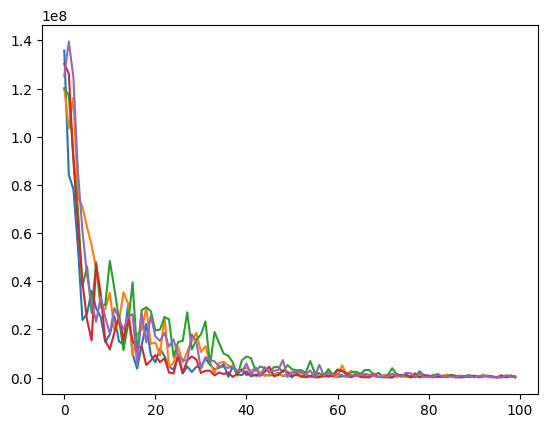

In [154]:
plt.figure()
for i in range(num_models):
    plt.plot(range(n_epochs), losses[i])
plt.show()

[1.0733161]


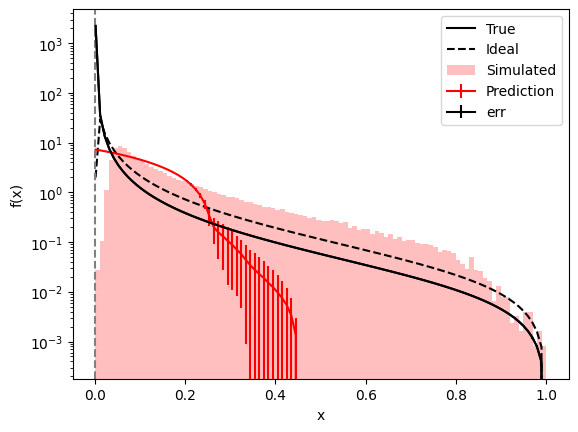

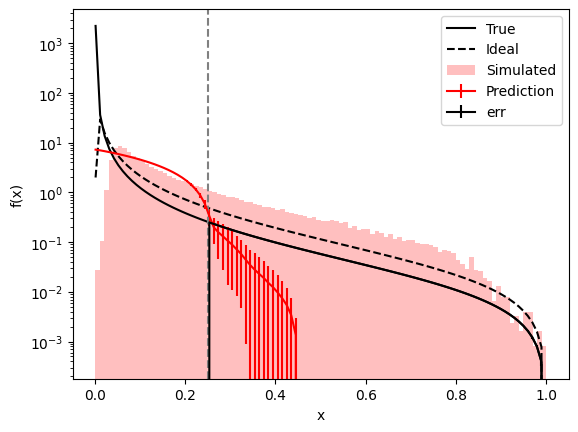

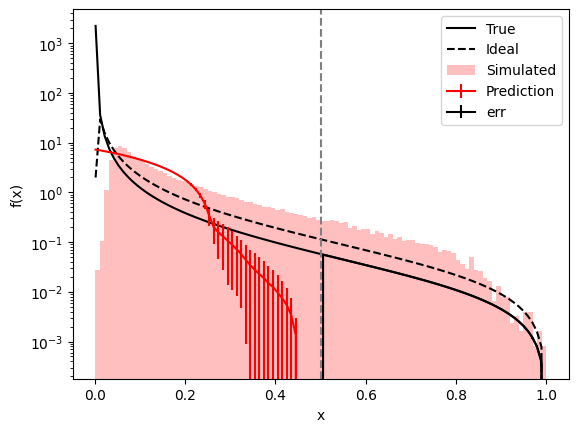

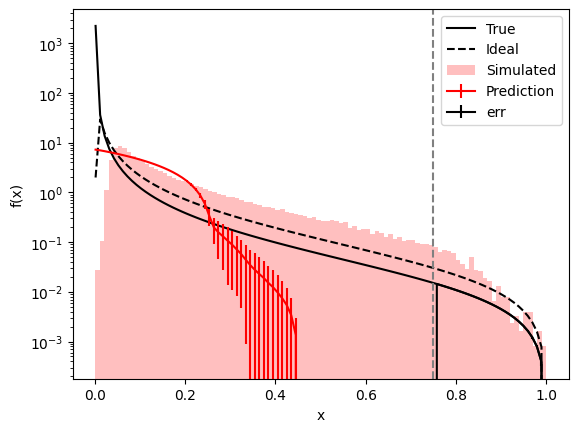

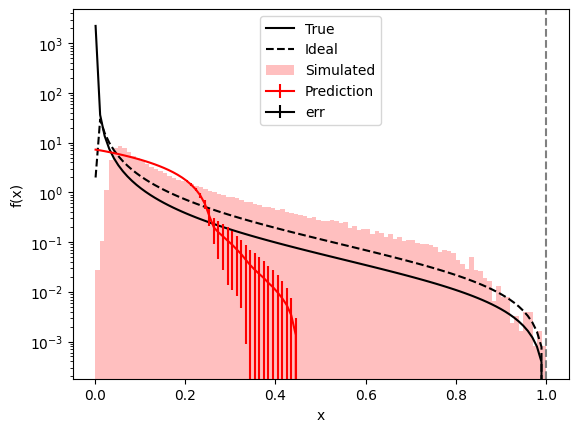

In [156]:
x_test = np.linspace(0.001, 1, 100).reshape(-1,1)    
x_test = np_to_torch(x_test, device)
y_test = f(x_test)  
y_ideal = true_f(x_test) * 2




x_test_cpu = x_test.detach().cpu().numpy()
y_test_cpu = y_test.detach().cpu().numpy()
y_ideal = y_ideal.detach().cpu().numpy()

print(np.sum(y_ideal) * (x_test_cpu[1] - x_test_cpu[0]))


Lambdas_test = [0, 0.25, 0.5, 0.75, 1]

simulated_angularities = np.load('normalized_angularity.npy')

for Lambda_test in Lambdas_test:

    y_preds = [dense_nets[i](x_test).detach().cpu().numpy() for i in range(num_models)]
    y_preds = np.array(y_preds)
    y_pred = np.mean(y_preds, axis=0)
    y_std = np.std(y_preds, axis=0)
    
    
    

    plt.figure()
    plt.plot(x_test_cpu, y_test_cpu, label='True', color = 'black')
    plt.plot(x_test_cpu, y_ideal, label='Ideal', color = 'black', ls = "--")
    plt.errorbar(x_test_cpu, y_pred[:,0], yerr=y_std[:,0], label='Prediction', color='red')
    plt.hist(simulated_angularities, bins=100, density=True, histtype='stepfilled', label='Simulated', color='red', alpha = 0.25)



    acceptable_error =  ((alpha_s(x_test * E0)**2)**2).detach().cpu().numpy()
    mask = x_test_cpu > Lambda_test
    
    yerr = acceptable_error*mask

    
    plt.errorbar(x_test_cpu, (y_test_cpu*mask).reshape(-1,), yerr=yerr.reshape(-1,), label='err', color='black')
    
    plt.axvline(Lambda_test, color='grey', linestyle='--')

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.yscale('log')
    plt.legend()
